Before we start, I want to state that this notebook is done by me, I'm just get used to English documents. This is not copied from some English or Indian guys.


# Reinforcement Learning is not only on fixed dataset.

Like a baby, these models will try different actions, learn experiencies on how the environment acting with them without third-party supervision.

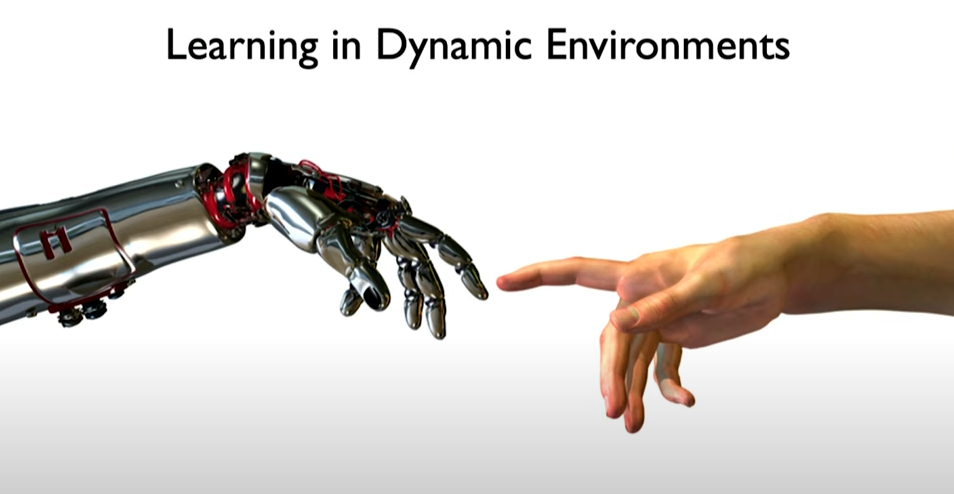


# Flashback

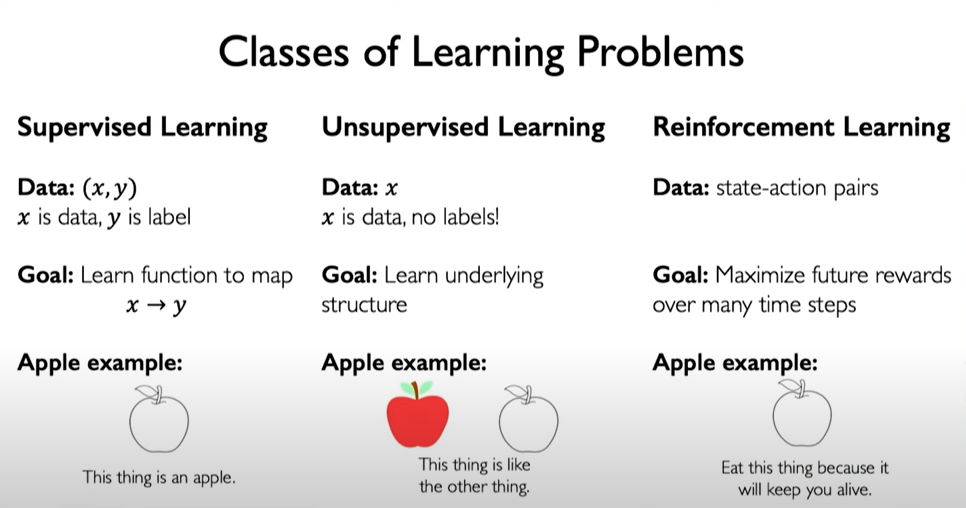

# Key Concepts

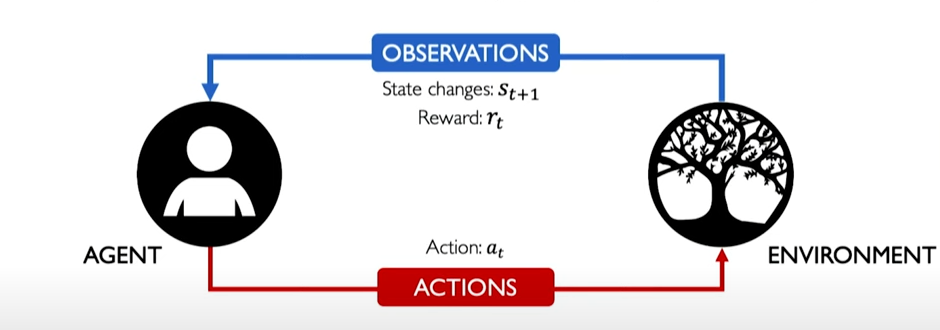

Agent: take actions.

Environment: the world in which the agent exists and operates.

Action: a move the agent can make in the environment

Action space $A$: the set of possible actions

Observations: of the environment after taking actions

State: a situation which the agent perceives

Reward: feedback that measures the success or failure of the agent's action

# Rewards

## Total reward

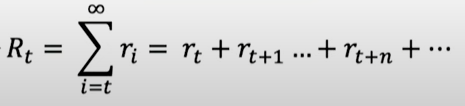

## Discounted total reward

Think about buying the same car in 2000 and 2020.

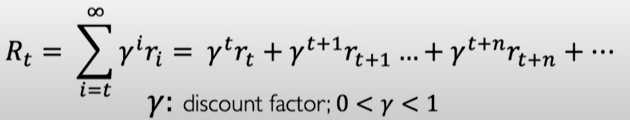

# The Q-function

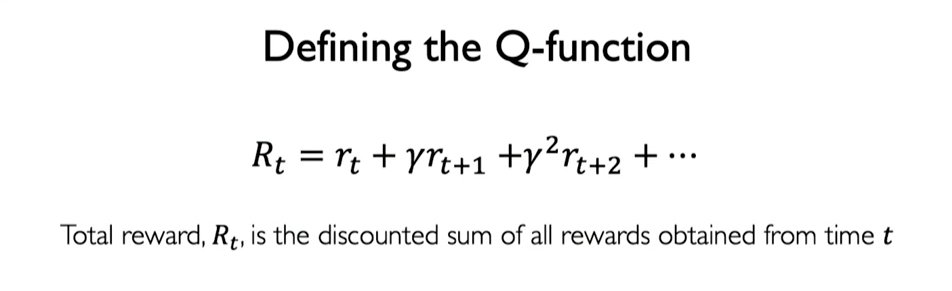

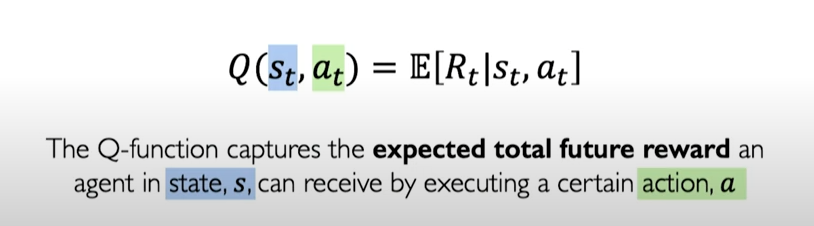

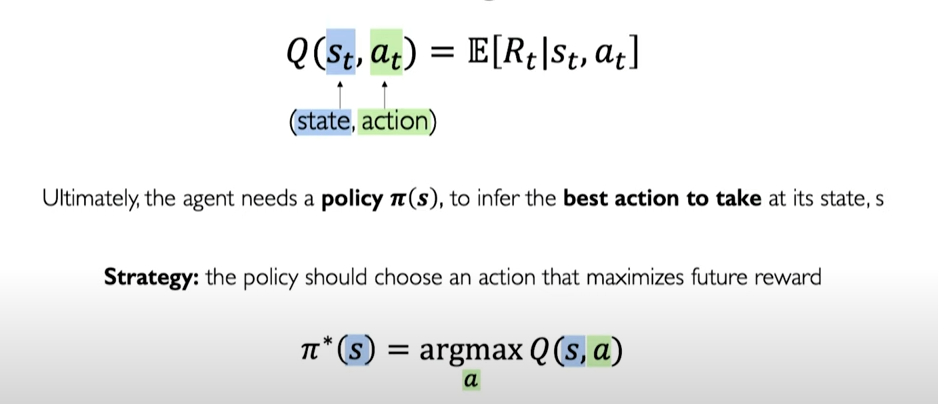

# Value and Policy

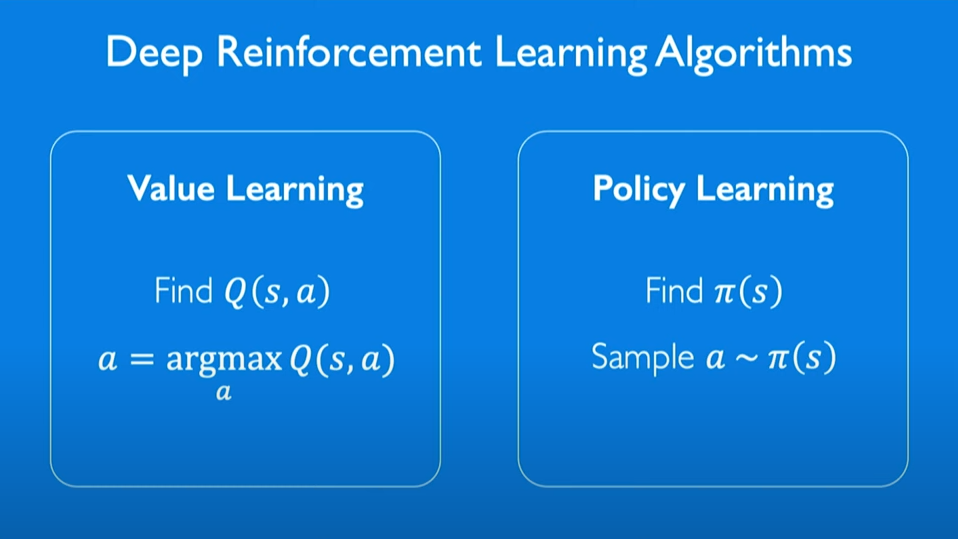

# Problem: Self-Driving Cab

Let's design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

+ Drop off the passenger to the right location.
+ Save passenger's time by taking minimum time possible to drop off.
+ Take care of passenger's safety and traffic rules.

There are different aspects that need to be considered here while modeling an RL solution to this problem: **rewards**, **states**, and **actions**.

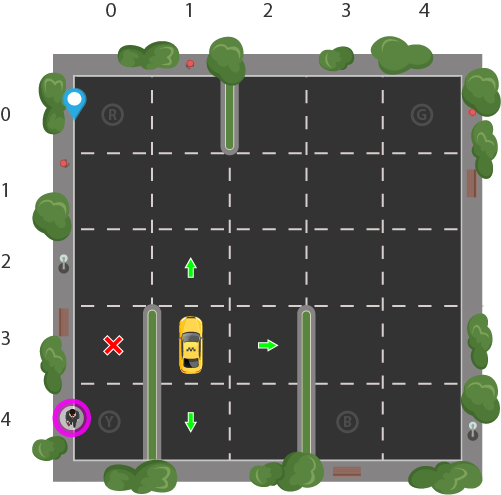

## Rewards:

+ Reward: receive a high positive reward for a successful dropoff because this behavior is highly desired.

+ Huge penalty: drop off a passenger in wrong locations.

+ Slightly penalty: will be receive every time steps, the longer its solution is, the bigger penalty it receives.

## State space:

Considering the following map:

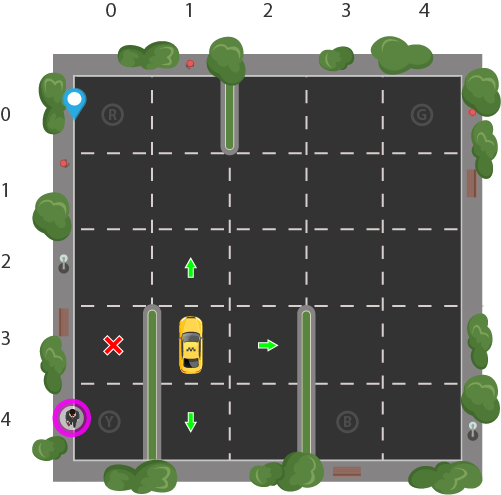

We have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B).

Let's say this is the only vehicle in this parking lot. This parking lot can be broken up to a 5x5 grid, give us 25 different locations.

The current location state of our taxi is coordinate (3, 1).

There are four locations that we can pick up and drop off a passenger: (R, G, Y, B), or \[(0,0), (0,4), (4,0), (4,3)\].

Our illustrated passenger is in location Y and they wish to go to location R. There are 4 such destinations.

We pick the passenger from any location, adding that after picking up the passenger will be inside the taxi, so there will be 5 passenger locations.

Summary: the number of possible states is (5 x 5) x 5 x 4 = 500 states.

## Action space:

Actions that the vehicle can make: 

+ Go south
+ Go north
+ Go east
+ Go west
+ Pickup
+ Dropoff

# Implementation

## Installing gym, cmake and pygame is required

OpenAI gym has the exactly environment we need, it is called "Taxi-v3"

In [5]:
# !pip install cmake
# !pip install pygame
# !pip install gym[atari]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Loading the game environment

In [6]:
import gym

env = gym.make("Taxi-v3").env

env.reset()

env.render()

AssertionError: Something went wrong with pygame. This should never happen.

The core gym interface is called `env`. Its methods are:

* `env.reset`: Resets the environment and returns a random initial state.

* `env.step(action)`: Step the environment by one timestep. Returns:

    + Observation: Observations of the environment.

    + Reward: If your action was beneficial or not.

    + Done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode.
    
    + Info: Additional info such as performance and latency for debugging purposes.

+ `env.render`: Renders one frame of the environment (helpful in visualizing the environment).

### From Gym docs:

`There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.`

### Let's try a new random state

In [ ]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

### Render a fixed state

Recall the order locations: (R, G, Y, B)

From the image above, we have the taxi at row 3, column 1, our passenger is at location 2, and our destination is location 0.

In [ ]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

### The reward table

In [ ]:
display(env.P[328])

From left to right: `[(probability, nextstate, reward, done)]`

Note:

+ In this env, `probability` is always 1.0.

+ The nextstate is the state we would be in if we take the action at this index of the dict.

+ All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action.

+ `done` is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

## Q-learning

Essentially, Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

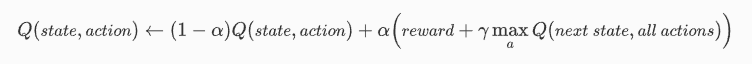

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

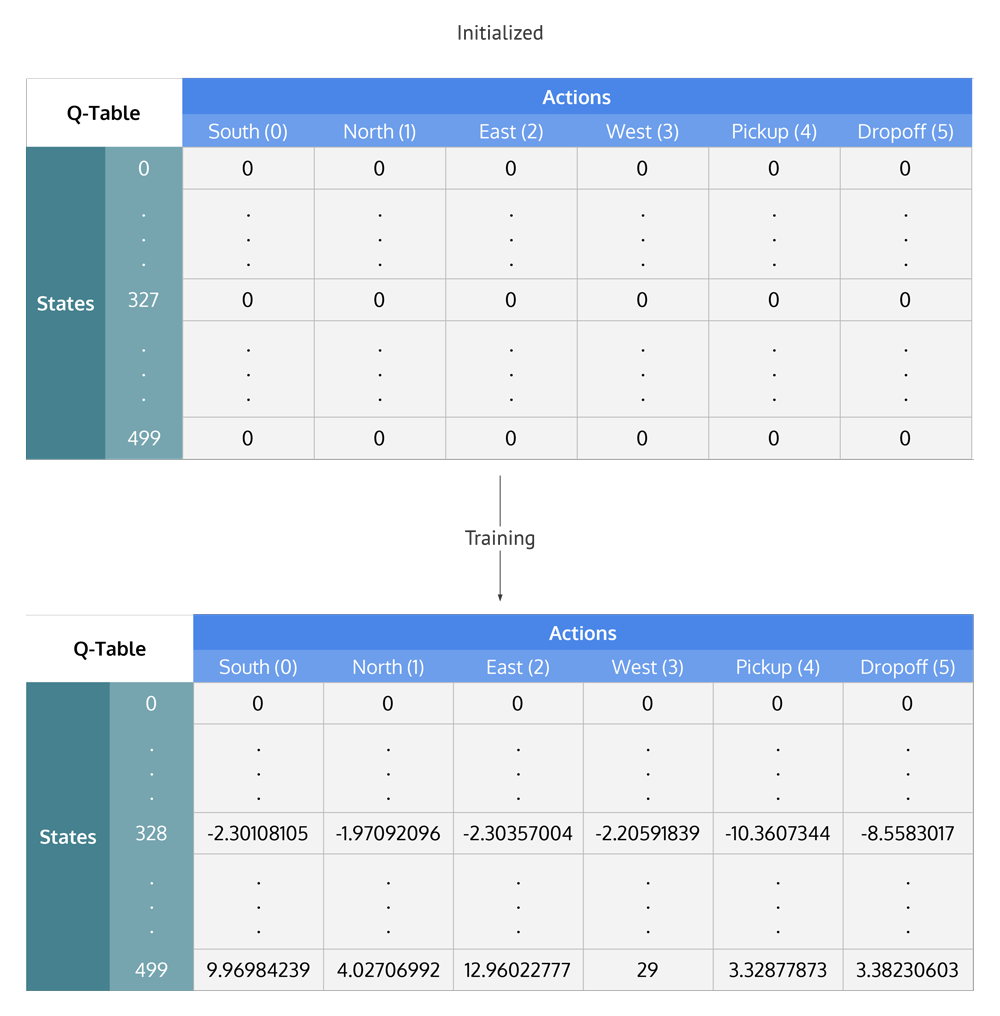

Breaking it down into steps, we get:

+ Initialize the Q-table by all zeros.

+ Start exploring actions: For each state, select any one among all possible actions for the current state `(S)`.

+ Travel to the next state `(S')` as a result of that action `(a)`.

+ For all possible actions from the state `(S')` select the one with the highest Q-value.

+ Update Q-table values using the equation.

+ Set the next state as the current state.

+ If goal state is reached, then end and repeat the process.

### Exploiting learned values

After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called $\epsilon$ `epsilon` to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

### Training the Agent:

First, we'll initialize the Q-table to a $500 \times 6$ matrix of zeros:

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Picking up hyperparameters, you can use random.uniform(0, 1) instead
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        # Determind what to do next
        
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
            # env.action_space.sample() automatically selects one random action from set of all possible actions.
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
            # Returning a state with the highest score.
        
        # Simulating the next action
        
        next_state, reward, done, info = env.step(action) 
        
        # Calculation using above equation
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        # Determind if we have a big penalty

        if reward == -10:
            penalties += 1
            
        # Moving to the next state

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

In [ ]:
display(q_table[328])

# Good luck coding! From CodeMely